# ST1504 Deep Learning CA1

- **Name:**     Jeyakumar Sriram  
- **Adm. No.:** 2214618  
- **Class:**    DAAA/FT/2B/01  

## Objective
Create a CNN model to perform image classification on a vegetables dataset with 15 classes.

## References
- Vaswani, A.; Shazeer, N.; Parmar, N.; Uszkoreit, J.; Jones, L.; Gomez, A. N.; Kaiser, Ł. & Polosukhin, I. (2017), Attention is all you need, in 'Advances in Neural Information Processing Systems' , pp. 5998--6008 .
- Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit, and Neil Houlsby. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.
- Ali Hassani, Steven Walton, Nikhil Shah, Abulikemu Abuduweili, Jiachen Li, and Humphrey Shi. (2022). Escaping the Big Data Paradigm with Compact Transformers.
- Hongyi Zhang, Moustapha Cisse, Yann N. Dauphin, and David Lopez-Paz. (2018). mixup: Beyond Empirical Risk Minimization.
- Asher Trockman, and J. Zico Kolter. (2022). Patches Are All You Need?.




## Libraries

In [33]:
# Basics
import numpy as np
import pandas as pd
import os
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

import warnings
warnings.filterwarnings("ignore")

## Utility Code

In [34]:
ROOT = "/kaggle/input/vegetable-images/Vegetable Images"
CLASSES = os.listdir(ROOT+"/train")
tfClasses = tf.constant(CLASSES)
TRAIN = tf.data.Dataset.list_files(f"{ROOT}/train/*/*")
TEST = tf.data.Dataset.list_files(f"{ROOT}/test/*/*")
VAL = tf.data.Dataset.list_files(f"{ROOT}/validation/*/*")
dataCats = ["train","test","validation"]

In [35]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [36]:
def plot_multiple_training_history(histories):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for history, model_name in histories:
        #axes[0].plot(history.history['accuracy'], label=f'{model_name} Train')
        axes[0].plot(history.history['val_accuracy'], label=f'{model_name} Validation')

        #axes[1].plot(history.history['loss'], label=f'{model_name} Train')
        axes[1].plot(history.history['val_loss'], label=f'{model_name} Validation')
        
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='upper left')

    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper left')

    plt.show()

In [37]:
def make_confusion_matrix(true_class, pred_class):
    cm = confusion_matrix(true_class, pred_class)
    plt.figure(figsize=(24, 20))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.ylabel("True values", size=20)
    plt.xlabel('Predicted values', size=20)
    plt.xticks(ticks=np.arange(len(CLASSES)) + 0.5, labels=CLASSES, rotation=60)
    plt.yticks(ticks=np.arange(len(CLASSES)) + 0.5, labels=CLASSES, rotation=0)

## Exploratory Data Analysis

Total Number of Images: 15028


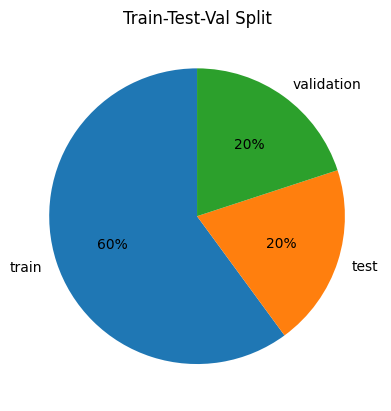

In [38]:
counts = [TRAIN.cardinality().numpy(),TEST.cardinality().numpy(),VAL.cardinality().numpy()]
print(f"Total Number of Images: {sum(counts)}")
plt.pie(x = counts,labels = dataCats,startangle=90, autopct='%1.0f%%')
plt.title('Train-Test-Val Split')
plt.show()

Observations:
- Train test validation split looks fine
- Usually its 80-10-10 but I can work with this
- 15000 images is considered small for image classification so we might have to use simpler models

Number of Classes: 15


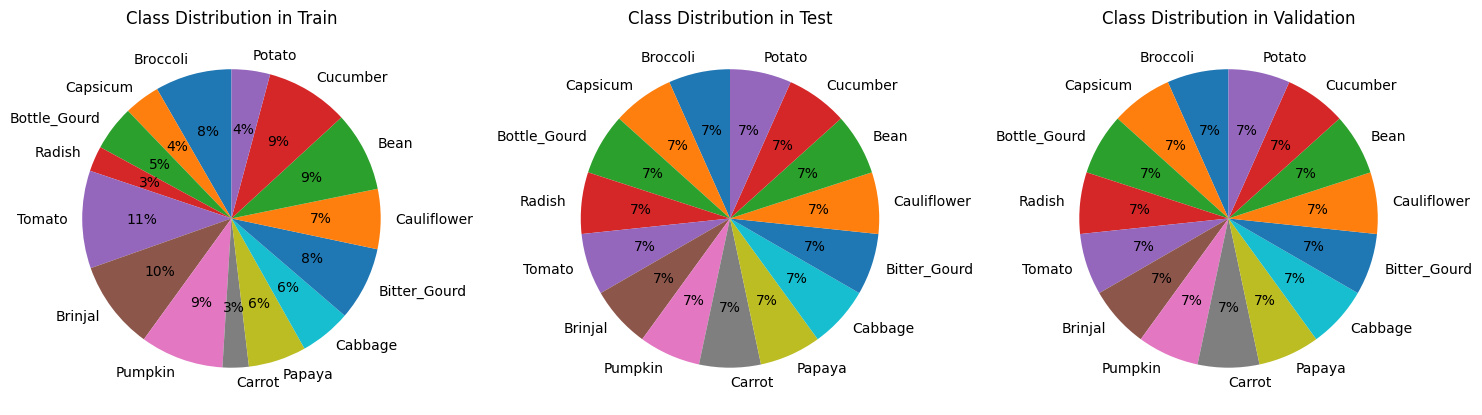

In [39]:
print(f"Number of Classes: {len(CLASSES)}")

classCounts = []
for cat in dataCats:
    class_distro = [len(tf.data.Dataset.list_files(f"{ROOT}/{cat}/{i}/*")) for i in CLASSES]
    classCounts.append(class_distro)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].pie(x = classCounts[i],labels=CLASSES, startangle=90, autopct='%1.0f%%')
    ax[i].set_title(f"Class Distribution in {dataCats[i].capitalize()}")
plt.tight_layout()
plt.show()

Observations:
- Train data is the only one with class imbalance and its bad
- Carrot and radish have the lowest amount of images and thats bad

I will try to balance the classes by augmenting existing images in select quantities to acheive equal class distribution

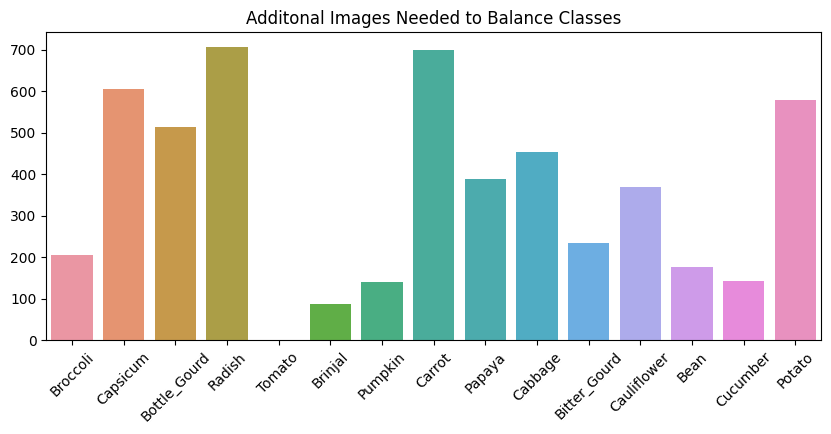

In [40]:
train_distro = classCounts[0]

targetSize = max(train_distro)
additional_needed = [targetSize-i for i in train_distro]

plt.figure(figsize=(10, 4))
sns.barplot(y=additional_needed, x = CLASSES)
plt.title('Additonal Images Needed to Balance Classes')
plt.xticks(rotation=45)
plt.show()

Observations:
- We need to augment alot of images of Radish and Carrots to balance the classes
- Tomato is fine here
- Classes which have alot of augmentation may not be as easy to predict as those with alot of original images

In [41]:
imgsPath = []
tempClasses = CLASSES

for i in TRAIN.as_numpy_iterator():
    if len(imgsPath) == 15:
        break
    if i.decode("utf-8").split("/")[-2] in tempClasses:
        imgsPath.append(i.decode("utf-8"))
        tempClasses = [k for k in tempClasses if k != i.decode("utf-8").split("/")[-2]]

For computational efficiency, instead of listing all the files and choosing one from each class, I will iterate through the tf dataset and pick 15

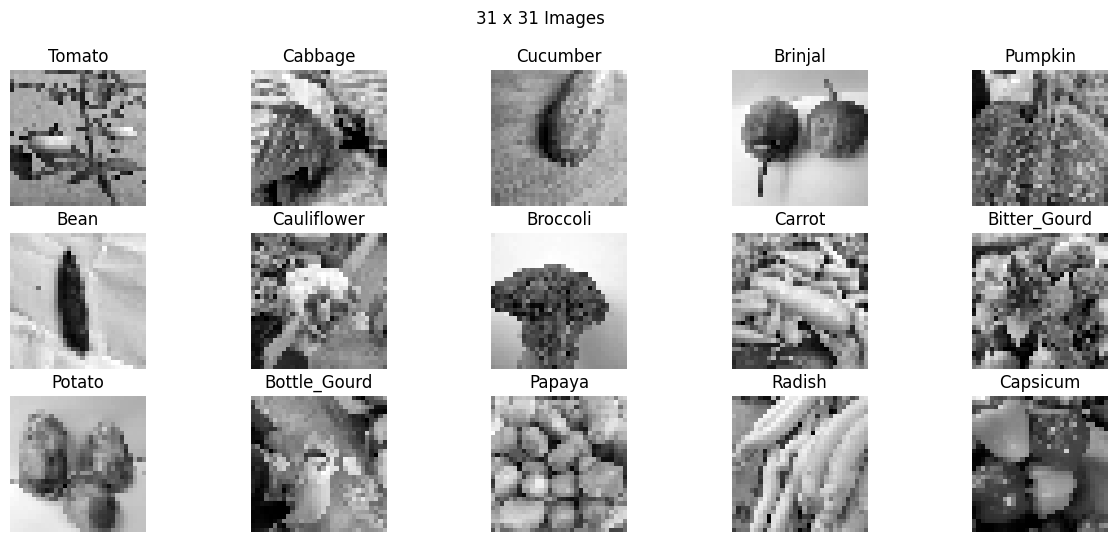

In [42]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
row, col = 0, 0
fig.suptitle("31 x 31 Images")

for path in imgsPath:
    label = path.split(os.path.sep)[-2]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (31, 31))
    img = img / 255.0
    axes[row, col].imshow(img,cmap="gray")
    axes[row, col].set_title(label)
    axes[row, col].axis('off')
    if col == 4:
        col = 0
        row += 1
    else:
        col += 1
plt.show()

Observations:
- 31 x 31 is going to be hard for the model to predict 
- I can barely tell between a potato, a papaya and a brinjal
- Cauliflowers, carators and pumpkin are quite distict and maybe be easy to predict

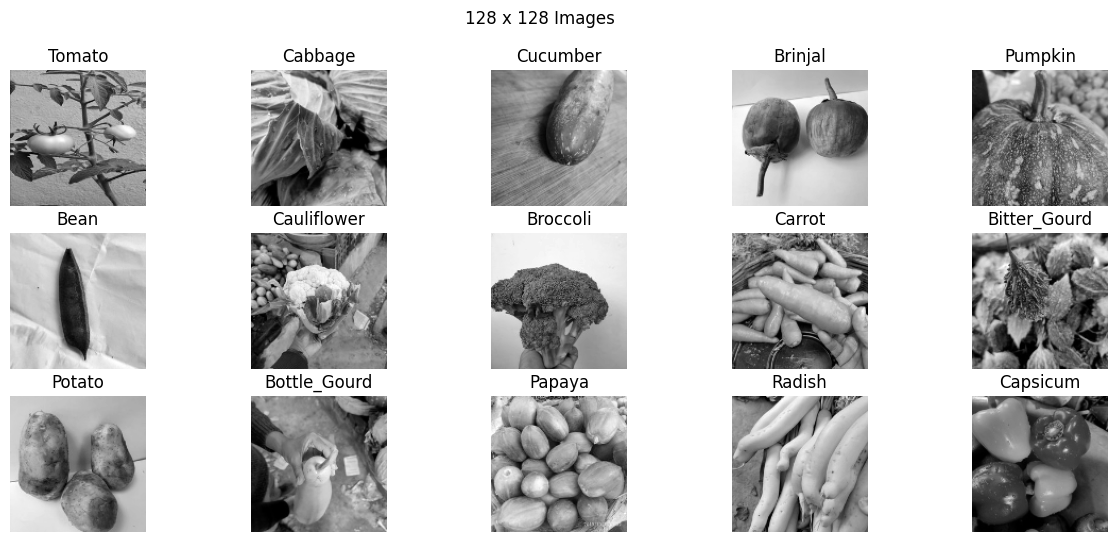

In [43]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
row, col = 0, 0
fig.suptitle("128 x 128 Images")
for path in imgsPath:
    label = path.split(os.path.sep)[-2]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    axes[row, col].imshow(img,cmap="gray")
    axes[row, col].set_title(label)
    axes[row, col].axis('off')
    if col == 4:
        col = 0
        row += 1
    else:
        col += 1
plt.show()

Observations:
- This resolution is much much better as you can see more detail from the vegetables
- Lack of color may make it hard to differentiate cucumbers and bottle gourds
- Different pictures have diff background so we need find a way to ignore it

## Preprocessing

Here I have 2 objectives:
- Augment existing data to address class imbalance
- Create new augmented data to address overfitting in models

I will be using 2 techniques here:
1. Simple augmentation: Flipping, cropping, zooming, etc.
2. MixUp: Take two images and mix them up and mix the classes accordingly

My Idea is simple, I will first train the model with balanced data, then once it starts overfitting, I will switch to fitting with the MixUp data.

In [44]:
print(CLASSES)
additional_needed

['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']


[205, 604, 514, 707, 0, 87, 141, 699, 389, 452, 235, 368, 175, 143, 578]

We gotta augment images to create specific numbers of each class

In [45]:
aug_train = []
for i,v in enumerate(CLASSES):
    path = f'{ROOT}/train/{v}'
    imgNeeded = additional_needed[i]
    images = os.listdir(path)[:imgNeeded]
    aug_train.extend([path + "/" + i for i in images])
train_data_aug = tf.data.Dataset.from_tensor_slices(aug_train)

Now, I will define the preprocessing functions, that will be used.

In [46]:
def createPreprocessor(imgSize):
    def processing(path):
        label = tf.strings.split(path , os.path.sep)
        one_hot = label[-2] == tfClasses
        label = tf.argmax(one_hot)
        label = tf.one_hot(label, depth=len(CLASSES))
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [imgSize, imgSize])
        img = tf.image.rgb_to_grayscale(img)
        img = img / 255.0
        return img , label
    return processing
    
def augmentation(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image , label

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

I will make it such that the preprocessing function can handle both shapes. I will use recommendations from Tensorflow documentation to batch and pefetch data.

In [47]:
train_ori_small = TRAIN.map(createPreprocessor(31))
train_aug_small = TRAIN.map(createPreprocessor(31)).map(augmentation)
train_small_ds = train_ori_small.concatenate(train_aug_small)
train_small = configure_for_performance(train_small_ds)

train_ori_large = TRAIN.map(createPreprocessor(128))
train_aug_large = TRAIN.map(createPreprocessor(128)).map(augmentation)
train_large_ds = train_ori_large.concatenate(train_aug_large)
train_large = configure_for_performance(train_large_ds)

test_small_ds = TEST.map(createPreprocessor(31))
val_small_ds = VAL.map(createPreprocessor(31))
test_small = configure_for_performance(test_small_ds)
val_small = configure_for_performance(val_small_ds)

test_large_ds = TEST.map(createPreprocessor(128))
val_large_ds = VAL.map(createPreprocessor(128))
test_large = configure_for_performance(test_large_ds)
val_large = configure_for_performance(val_large_ds)

Afte concatenating the augmented datasets, the train data is now balanced.

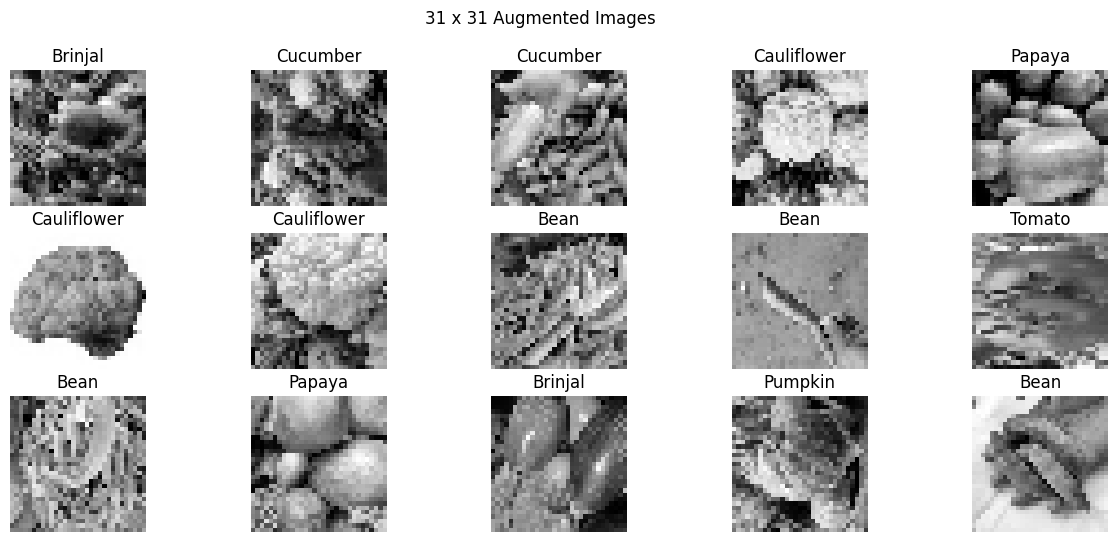

In [48]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
row, col = 0, 0

fig.suptitle("31 x 31 Augmented Images")

for i in train_aug_small.take(15):
    label = tf.argmax(i[1]).numpy()
    axes[row, col].imshow(i[0],cmap="gray")
    axes[row, col].set_title(CLASSES[label])
    axes[row, col].axis('off')
    if col == 4:
        col = 0
        row += 1
    else:
        col += 1

Its around the same just that it might be filliped to rotated.

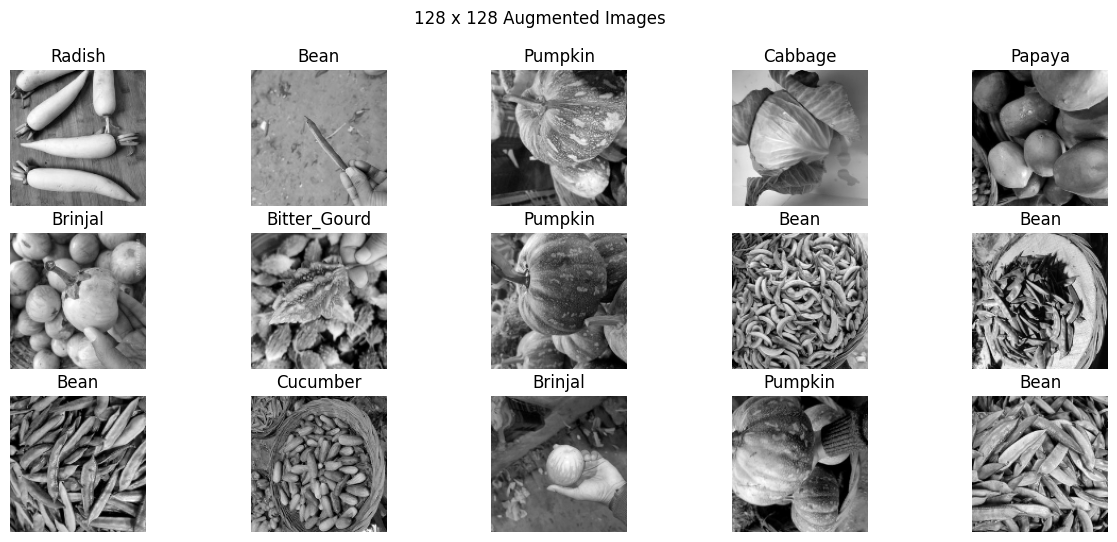

In [49]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
row, col = 0, 0

fig.suptitle("128 x 128 Augmented Images")

for i in train_aug_large.take(15):
    label = tf.argmax(i[1]).numpy()
    axes[row, col].imshow(i[0],cmap="gray")
    axes[row, col].set_title(CLASSES[label])
    axes[row, col].axis('off')
    if col == 4:
        col = 0
        row += 1
    else:
        col += 1

Augmentation here is not really to add noise but to create new images. So even if these images dont look noisy, its fine. We will add noise using the next method.

In [50]:
def beta_distribution(batch_size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[batch_size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[batch_size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

This function creates a beta distribution like this. 

![beta distrbution image](https://forums.fast.ai/uploads/default/original/2X/1/141fb5bab1e1f66bebaf7d1f90443eb7f832e566.png)

The reason why I choose this distrbution is because values tend to be closer to 0 and 1 which is shown to be better. If values are like 0.5 then you will have half of each image which will confuse the model more.

In [51]:
def mix_up(ds1, ds2, alpha=0.2):
    
    images1, labels1 = ds1
    images2, labels2 = ds2
    
    batch_size = 32
    proportions = beta_distribution(batch_size, alpha, alpha)
    
    x_l = tf.reshape(proportions, (batch_size, 1, 1, 1))
    y_l = tf.reshape(proportions, (batch_size, 1))
    
    images = images1 * x_l + images2 * (1 - x_l)
    
    labels = labels1 * y_l + labels2 * (1 - y_l)
    
    return (images, labels)

I also did one hot here before merging the labels as if I dont, I will get values like 3.1 which I cannot one hot

In [52]:
train_mixup_small = tf.data.Dataset.zip((train_small_ds,train_small_ds))
train_mixup_small = train_mixup_small.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=tf.data.AUTOTUNE
).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_mixup_large = tf.data.Dataset.zip((train_large_ds,train_large_ds))
train_mixup_large = train_mixup_large.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=tf.data.AUTOTUNE
).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

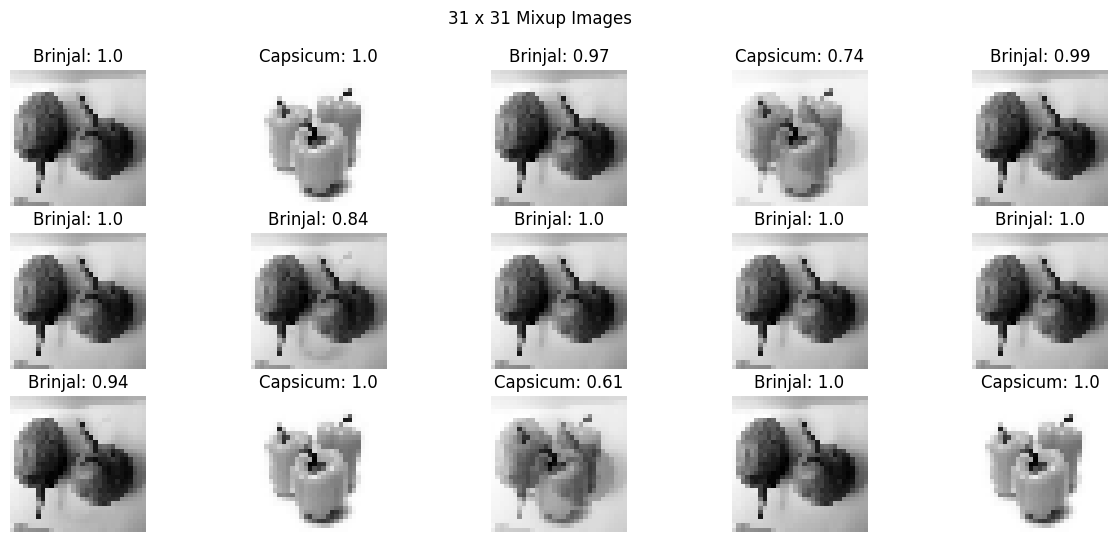

In [53]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
row, col = 0, 0

fig.suptitle("31 x 31 Mixup Images")

for batch in train_mixup_small.take(1):
    images = batch[0][:15,:,:]
    labels = batch[1][:15,:]
    for i in range(15):
        label = tf.math.argmax(labels[i]).numpy()
        proba = labels[i][label].numpy()
        proba = tf.cast(proba,tf.float64)
        axes[row, col].imshow(images[i].numpy(),cmap="gray")
        axes[row, col].set_title(f"{CLASSES[label]}: {np.round(proba.numpy(),2)}")
        axes[row, col].axis('off')
        if col == 4:
            col = 0
            row += 1
        else:
            col += 1

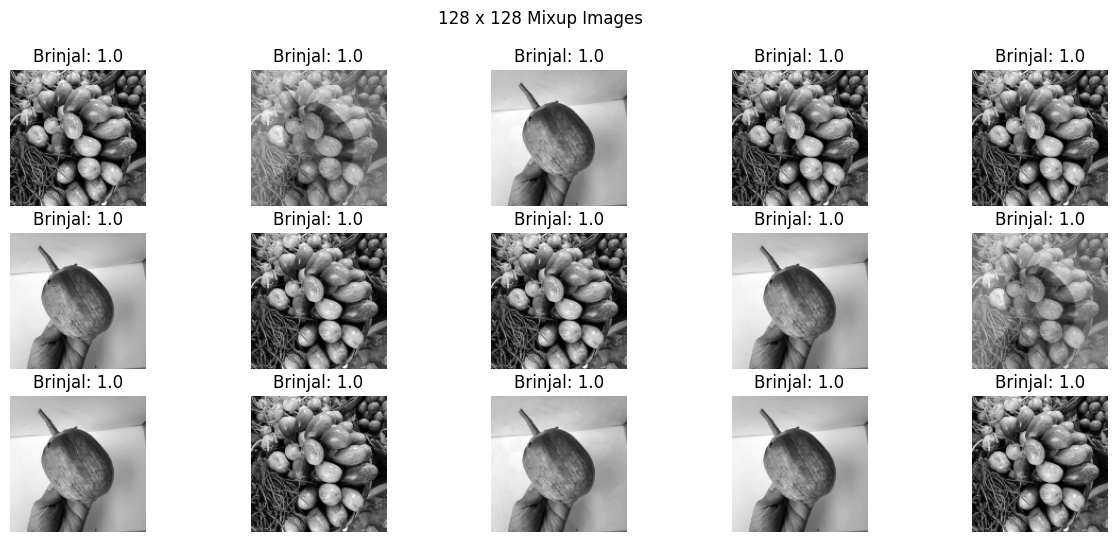

In [54]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
row, col = 0, 0

fig.suptitle("128 x 128 Mixup Images")

for batch in train_mixup_large.take(1):
    images = batch[0][:15,:,:]
    labels = batch[1][:15,:]
    for i in range(15):
        label = tf.math.argmax(labels[i]).numpy()
        proba = labels[i][label].numpy()
        proba = tf.cast(proba,tf.float64)
        axes[row, col].imshow(images[i].numpy(),cmap="gray")
        axes[row, col].set_title(f"{CLASSES[label]}: {np.round(proba.numpy(),2)}")
        axes[row, col].axis('off')
        if col == 4:
            col = 0
            row += 1
        else:
            col += 1

## Modelling

For this section, I will first try to predict the 31 x 31 image and then move on to the 128 x 128 images.



In [55]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)

### 31 x 31

In [56]:
base_cnn_model = tf.keras.Sequential([
  Conv2D(16, 3, activation='relu',input_shape=(31,31,1)),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(64),
  Dense(15, activation="softmax")
])

In [57]:
base_cnn_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
modelHist = base_cnn_model.fit(
      train_small, validation_data=val_small,
      epochs=20, callbacks=[es,reduce_lr]
    )

Epoch 1/20
565/565 [==============================] - 12s 17ms/step - loss: 2.3093 - accuracy: 0.2226 - val_loss: 2.3874 - val_accuracy: 0.2490 - lr: 0.0010
Epoch 2/20
565/565 [==============================] - 2s 4ms/step - loss: 1.8330 - accuracy: 0.3942 - val_loss: 1.8609 - val_accuracy: 0.3817 - lr: 0.0010
Epoch 3/20
565/565 [==============================] - 2s 4ms/step - loss: 1.5738 - accuracy: 0.4786 - val_loss: 1.7993 - val_accuracy: 0.3843 - lr: 0.0010
Epoch 4/20
565/565 [==============================] - 2s 4ms/step - loss: 1.3939 - accuracy: 0.5433 - val_loss: 1.7078 - val_accuracy: 0.4210 - lr: 0.0010
Epoch 5/20
565/565 [==============================] - 2s 4ms/step - loss: 1.2744 - accuracy: 0.5831 - val_loss: 1.6667 - val_accuracy: 0.4453 - lr: 0.0010
Epoch 6/20
565/565 [==============================] - 3s 4ms/step - loss: 1.1645 - accuracy: 0.6168 - val_loss: 1.5502 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 7/20
565/565 [==============================] - 2s 4ms/step - 

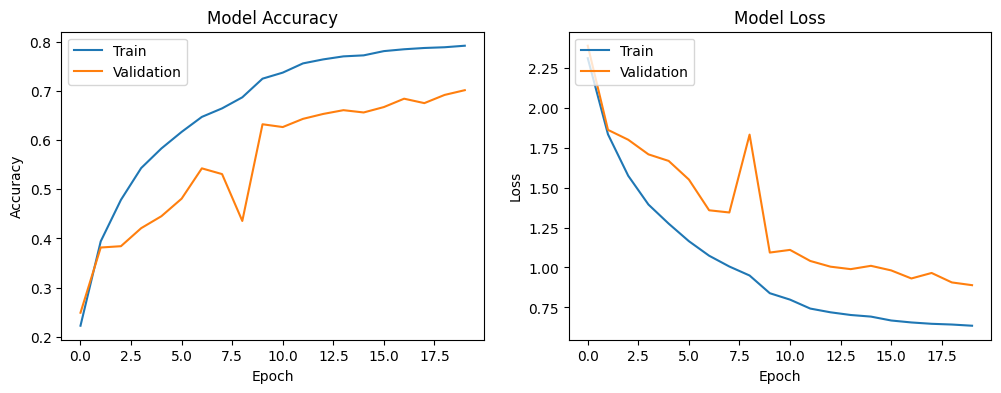

In [58]:
plot_training_history(modelHist)
base_cnn_model.save('base_cnn_small.keras')

This model does ok but accuracy plateau. I should add some dropout to prevent overfitting and batchnormalisation for stability.

In [59]:
reg_cnn_model = tf.keras.Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(31, 31, 1)),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(32, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(15, activation='softmax')
])

In [60]:
reg_cnn_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
modelHist = reg_cnn_model.fit(
      train_small, validation_data=val_small,
      epochs=20, callbacks=[es,reduce_lr]
    )


Epoch 1/20
565/565 [==============================] - 6s 6ms/step - loss: 2.3343 - accuracy: 0.2495 - val_loss: 2.1327 - val_accuracy: 0.2807 - lr: 0.0010
Epoch 2/20
565/565 [==============================] - 3s 5ms/step - loss: 1.8905 - accuracy: 0.3718 - val_loss: 2.8088 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 3/20
565/565 [==============================] - 3s 5ms/step - loss: 1.6603 - accuracy: 0.4405 - val_loss: 2.0652 - val_accuracy: 0.3187 - lr: 5.0000e-04
Epoch 4/20
565/565 [==============================] - 3s 5ms/step - loss: 1.5334 - accuracy: 0.4820 - val_loss: 2.1939 - val_accuracy: 0.3610 - lr: 5.0000e-04
Epoch 5/20
565/565 [==============================] - 3s 5ms/step - loss: 1.4340 - accuracy: 0.5153 - val_loss: 1.3874 - val_accuracy: 0.5407 - lr: 2.5000e-04
Epoch 6/20
565/565 [==============================] - 3s 5ms/step - loss: 1.3691 - accuracy: 0.5363 - val_loss: 1.3105 - val_accuracy: 0.5753 - lr: 2.5000e-04
Epoch 7/20
565/565 [==============================] - 

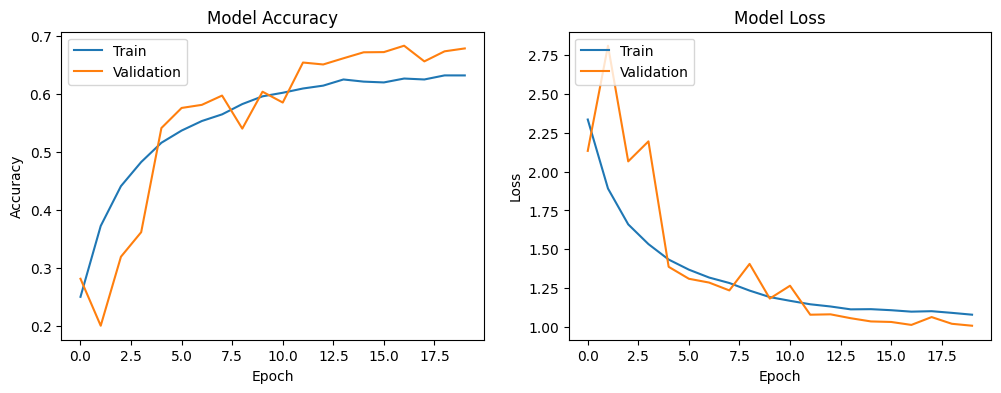

In [61]:
plot_training_history(modelHist)
reg_cnn_model.save('reg_cnn_small.keras')

Model takes slightly more epochs to train which makes sense as we added regularisation, but I feel that it doesnt have much potential as it began to plateau at 0.7.

I will now begin exploring the Vision Transformer Architecture for a higher val_accuracy.

#### Transformer Classes

In [62]:
class Patcher(Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchToEmbedding(Layer):
    def __init__(self, image_size, patch_size, embedding):
        num_patches = (image_size // patch_size) ** 2
        super().__init__()
        self.num_patches = num_patches
        self.embedding = Dense(units=embedding)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=embedding
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.embedding(patch) + self.position_embedding(positions)
        return encoded
    
class MLP(Layer):
    def __init__(self, layers, dropout_ratio):
        super().__init__()
        self.model = Sequential()
        for i in layers:
            self.model.add(Dense(i))
            self.model.add(Dropout(dropout_ratio))
    def call(self,x):
        return self.model(x)
    
class Transformer(Layer):
    def __init__(self, heads, keys, mlp_layers,dropout_ratio):
        super().__init__()
        self.normalisation = LayerNormalization(epsilon=1e-6)
        self.attention = MultiHeadAttention(num_heads=heads,
                                            key_dim=keys, 
                                            dropout=dropout_ratio)
        self.mlp = MLP(mlp_layers,dropout_ratio)
        self.add = Add()
    def call(self,x):
        x1 = self.normalisation(x)
        attention = self.attention(x1,x1)
        x2 = self.add([attention,x])
        x3 = self.normalisation(x2)
        x4 = self.mlp(x3)
        transformed = self.add([x4,x2])
        return transformed

#### Simple Vision Transformer

In [63]:
class SimpleVIT(keras.Model):
    def __init__(self, patch_size, image_size, embedding):
        super().__init__()
        self.chopper = Patcher(patch_size)
        self.embedding = PatchToEmbedding(image_size, patch_size, embedding)
        self.transformer = Transformer(4, 64, [256,128],0.1)
        self.normalise = LayerNormalization(epsilon=1e-6)
        self.flatten = Flatten()
        self.dropout = Dropout(0.5)
        self.mlp = MLP([2048,1024],0.5)
        self.classifier = Dense(15)
    
    def call(self,images):
        patches = self.chopper(images)
        x = self.embedding(patches)
        for i in range(8):
            x = self.transformer(x)
        x = self.normalise(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.mlp(x)
        prediction = self.classifier(x)
        return prediction

In [64]:
vit_classifier = SimpleVIT(8,31,128)
vit_classifier.compile(
        optimizer="adam",
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
history = vit_classifier.fit(
    train_small,validation_data=val_small,
    epochs=20, callbacks=[es]
)
vit_classifier.save('vit_small.keras')

Epoch 1/20
565/565 [==============================] - 25s 27ms/step - loss: 5.7144 - accuracy: 0.0847 - val_loss: 2.8076 - val_accuracy: 0.1367
Epoch 2/20
565/565 [==============================] - 14s 25ms/step - loss: 2.6314 - accuracy: 0.1573 - val_loss: 2.7100 - val_accuracy: 0.1403
Epoch 3/20
565/565 [==============================] - 14s 25ms/step - loss: 2.4834 - accuracy: 0.1885 - val_loss: 2.6201 - val_accuracy: 0.1520
Epoch 4/20
565/565 [==============================] - 14s 26ms/step - loss: 2.4694 - accuracy: 0.1872 - val_loss: 2.6703 - val_accuracy: 0.1147
Epoch 5/20
565/565 [==============================] - 14s 25ms/step - loss: 2.4451 - accuracy: 0.1982 - val_loss: 2.6124 - val_accuracy: 0.1417
Epoch 6/20
565/565 [==============================] - 15s 26ms/step - loss: 2.4736 - accuracy: 0.1881 - val_loss: 2.7097 - val_accuracy: 0.1310


Model performs bad. To combat this, I would like to modify the method of embedding. Right now it chops up a image into patches and encodes them into vectors. I will replace this with convolution. Where the outputs of convolution will be used as patches. Convolution is generally more effective for Images while transformers have more potential. I hope that this approach will reduce compleixty.

#### Convolutional Layers

In [65]:
class Convolution_Model(Layer):
    def __init__(self,channels):
        super().__init__()
        self.model = Sequential()
        for i in channels:
            self.model.add(Conv2D(i, 3, 1,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",))
            self.model.add(ZeroPadding2D(1))
            self.model.add(MaxPool2D(3, 2, "same"))
    def call(self,x):
        return self.model(x)

class ConvolutionalPatching(Layer):
    def __init__(self,channels):
        super().__init__()
        self.model = Convolution_Model(channels)

    def call(self,x):
        x = self.model(x)
        piece_len = tf.shape(x)[1] * tf.shape(x)[2]
        embedding = tf.shape(x)[-1]
        new_shape = (-1,piece_len,embedding)
        chopped = tf.reshape(x,new_shape)
        return chopped
    
class AddPosEmbedding(Layer):
    def __init__(self,img_size,model):
        super().__init__()
        self.model = model
        placeholder = tf.ones((1,img_size,img_size,1))
        outputs = model(placeholder)
        self.piece_len = tf.shape(outputs)[1] * tf.shape(outputs)[2]
        self.embeddingLen = tf.shape(outputs)[-1]
        self.embed = Embedding(input_dim = self.piece_len,
                    output_dim = self.embeddingLen)
    def call(self,x):
        positions = tf.range(start=0, 
                             limit=self.piece_len, 
                             delta=1)
        embeddings = self.embed(positions)
        x =  x + embeddings
        return x 

#### Compact Convolutional Transformers

In [66]:
class ConvTransformer(keras.Model):
    def __init__(self, patch_size, image_size, embedding):
        super().__init__()
        self.convPatch = ConvolutionalPatching([64,128])
        self.conv = Convolution_Model([64,128])
        self.embedding = AddPosEmbedding(image_size,self.conv)
        self.transformer = Transformer(4, 64, [256,128],0.1)
        self.normalise = LayerNormalization(epsilon=1e-6)
        self.dense = Dense(1)
        self.classifier = Dense(15)
    
    def call(self,images):
        x = self.convPatch(images)
        
        x = self.embedding(x)
        for i in range(8):
            x = self.transformer(x)
        x = self.normalise(x)
        weights = self.dense(x)
        weights =  tf.nn.softmax(weights,axis=1)
        x = tf.matmul(weights,x, transpose_a=True)
        x = tf.squeeze(x, -2)
        prediction = self.classifier(x)
        return prediction

In [67]:
cct_classifier = ConvTransformer(6,31,128)
cct_classifier.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )
history = cct_classifier.fit(
    train_small,validation_data=val_small,
    epochs=20, callbacks=[es,reduce_lr]
)
cct_classifier.save('cct_small.keras')

Epoch 1/20
565/565 [==============================] - 31s 34ms/step - loss: 2.5609 - accuracy: 0.1464 - val_loss: 2.9215 - val_accuracy: 0.1410 - lr: 0.0010
Epoch 2/20
565/565 [==============================] - 18s 32ms/step - loss: 2.0800 - accuracy: 0.2949 - val_loss: 1.9651 - val_accuracy: 0.3073 - lr: 0.0010
Epoch 3/20
565/565 [==============================] - 18s 32ms/step - loss: 1.7174 - accuracy: 0.4137 - val_loss: 1.7785 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 4/20
565/565 [==============================] - 18s 32ms/step - loss: 1.5745 - accuracy: 0.4651 - val_loss: 1.5973 - val_accuracy: 0.4637 - lr: 0.0010
Epoch 5/20
565/565 [==============================] - 18s 32ms/step - loss: 1.4182 - accuracy: 0.5223 - val_loss: 1.6330 - val_accuracy: 0.4497 - lr: 0.0010
Epoch 6/20
565/565 [==============================] - 19s 34ms/step - loss: 1.2072 - accuracy: 0.5956 - val_loss: 1.3906 - val_accuracy: 0.5400 - lr: 5.0000e-04
Epoch 7/20
565/565 [==============================] - 

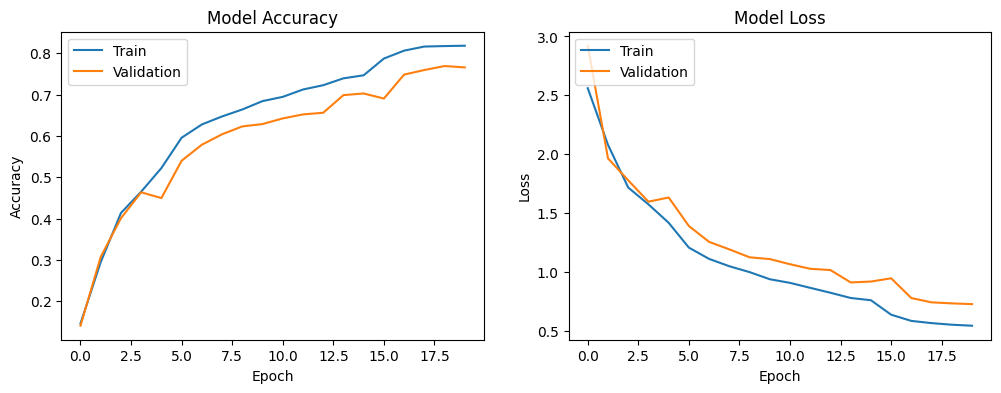

In [68]:
plot_training_history(history)

Model performs amazingly. The validation accuracy is pretty insane. Most importantly there is no sign of plateau which is good. I will probably work on this for my 31 x 31 data.

### 128 x 128

I will use the same conv transformers here

In [69]:
reg_cnn_model_large = tf.keras.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(256, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), 
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), 
    
    Dense(15, activation='softmax')
])

In [70]:
reg_cnn_model_large.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
modelHist = reg_cnn_model_large.fit(
      train_large, validation_data=val_large,
      epochs=20, callbacks=[es,reduce_lr]
    )


Epoch 1/20
565/565 [==============================] - 19s 24ms/step - loss: 1.9936 - accuracy: 0.4025 - val_loss: 4.2893 - val_accuracy: 0.1293 - lr: 0.0010
Epoch 2/20
565/565 [==============================] - 9s 17ms/step - loss: 1.2436 - accuracy: 0.6004 - val_loss: 1.5323 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 3/20
565/565 [==============================] - 9s 16ms/step - loss: 0.9086 - accuracy: 0.7121 - val_loss: 1.6296 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 4/20
565/565 [==============================] - 9s 16ms/step - loss: 0.6029 - accuracy: 0.8125 - val_loss: 1.6770 - val_accuracy: 0.6310 - lr: 5.0000e-04
Epoch 5/20
565/565 [==============================] - 9s 16ms/step - loss: 0.4226 - accuracy: 0.8702 - val_loss: 2.6282 - val_accuracy: 0.7097 - lr: 2.5000e-04
Epoch 6/20
565/565 [==============================] - 9s 16ms/step - loss: 0.3229 - accuracy: 0.9047 - val_loss: 2.6218 - val_accuracy: 0.8667 - lr: 1.2500e-04
Epoch 7/20
565/565 [==============================]

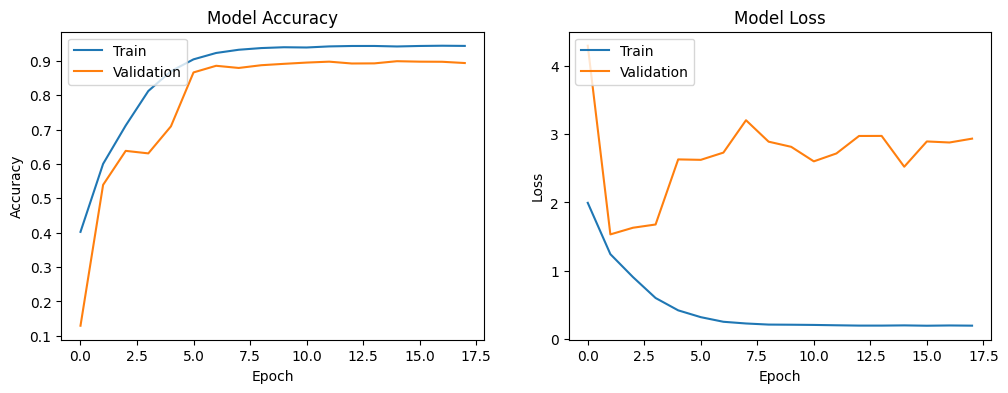

In [71]:
plot_training_history(modelHist)
reg_cnn_model_large.save('reg_model_large.keras')

Model accuracy is pretty good but the loss is confusing. The model has high loss but high accuracy. How?? I will use the same Concolutional transformers here as well

In [72]:
cct_classifier = ConvTransformer(16,128,128)
cct_classifier.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )
history = cct_classifier.fit(
    train_large, validation_data=val_large,
    epochs=1, callbacks=[es,reduce_lr]
)

565/565 [==============================] - 360s 619ms/step - loss: 2.4244 - accuracy: 0.1876 - val_loss: 2.1964 - val_accuracy: 0.2320 - lr: 0.0010


Takes wayyy too long. Almost 5 mins per epoch. I will add a conv layer to compress image using Conv and Pooling before passing in so it doesnt process at 128x128 pixels but maybe just 32 x 32

In [73]:
class SmallerConvTransformer(keras.Model):
    def __init__(self, patch_size, image_size, embedding):
        super().__init__()
        self.convPatch = ConvolutionalPatching([64,128])
        self.conv = Convolution_Model([64,128])
        self.compress = Convolution_Model([32])
        self.pool= MaxPooling2D()
        self.embedding = AddPosEmbedding(32,self.conv)
        self.transformer = Transformer(4, 64, [128,128],0.1)
        self.normalise = LayerNormalization(epsilon=1e-6)
        self.dense = Dense(1)
        self.classifier = Dense(15)
    
    def call(self,images):
        x = self.compress(images)
        x = self.pool(x)
        
        x = self.convPatch(x)
        
        x = self.embedding(x)
        for i in range(8):
            x = self.transformer(x)
        x = self.normalise(x)
        weights = self.dense(x)
        weights =  tf.nn.softmax(weights,axis=1)
        x = tf.matmul(weights,x, transpose_a=True)
        x = tf.squeeze(x, -2)
        prediction = self.classifier(x)
        return prediction

Reducing model complexity as it takes way too long on a bigger image

In [74]:
cct_classifier = SmallerConvTransformer(8,128,128)
cct_classifier.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )
history = cct_classifier.fit(
    train_large, validation_data=val_large,
    epochs=20, callbacks=[es,reduce_lr]
)
cct_classifier.save('cct_model_large.keras')

Epoch 1/20
565/565 [==============================] - 32s 38ms/step - loss: 2.2875 - accuracy: 0.2263 - val_loss: 1.9465 - val_accuracy: 0.3370 - lr: 0.0010
Epoch 2/20
565/565 [==============================] - 21s 37ms/step - loss: 1.4791 - accuracy: 0.5079 - val_loss: 1.3553 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 3/20
565/565 [==============================] - 21s 37ms/step - loss: 1.1096 - accuracy: 0.6351 - val_loss: 1.0575 - val_accuracy: 0.6363 - lr: 0.0010
Epoch 4/20
565/565 [==============================] - 21s 37ms/step - loss: 0.8897 - accuracy: 0.7083 - val_loss: 1.1218 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 5/20
565/565 [==============================] - 21s 37ms/step - loss: 0.6288 - accuracy: 0.7988 - val_loss: 0.7205 - val_accuracy: 0.7680 - lr: 5.0000e-04
Epoch 6/20
565/565 [==============================] - 21s 37ms/step - loss: 0.5517 - accuracy: 0.8220 - val_loss: 0.8250 - val_accuracy: 0.7340 - lr: 5.0000e-04
Epoch 7/20
565/565 [==============================

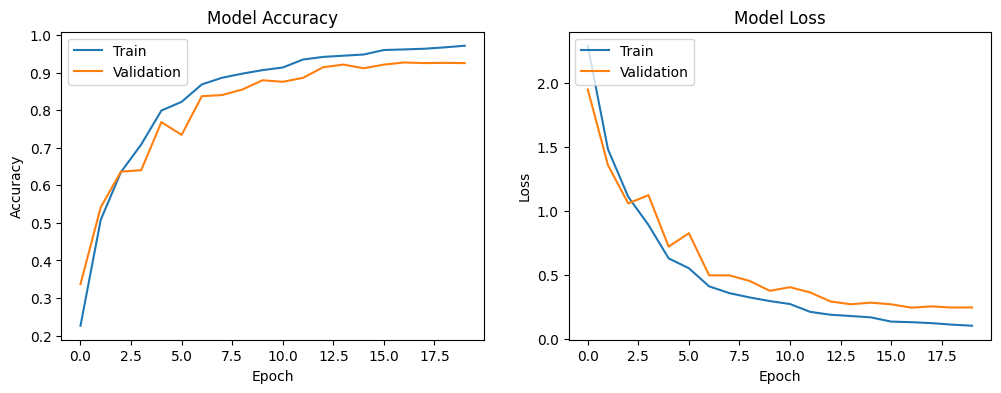

In [75]:
plot_training_history(history)

After putting the compression, it is wayy faster. Per epoch training time was reduced from 5mins to 20s.
Overall, Its pretty good at 93% validation accuracy. But I want to see if I can improve further. I will try to replace the transformer module in this whole model.

## Reducing Model Complexity

To further enhance my model to be efficient, I will aim to reduce parameters while maintaining efficiency.

Here, I will use slowly reduce the complexity of the model and compare the training curves to find a good balance. I will also make use of the augmented data to generalise my model even more.

### 31 x 31

In [76]:
class ConvTransformerTry(keras.Model):
    def __init__(self, patch_size, image_size, embedding,transformer_layers,conv_layers,transformer_count):
        super().__init__()
        self.convPatch = ConvolutionalPatching(conv_layers)
        self.conv = Convolution_Model(conv_layers)
        self.embedding = AddPosEmbedding(image_size,self.conv)
        self.transformer = Transformer(4, 64, transformer_layers,0.1)
        self.normalise = LayerNormalization(epsilon=1e-6)
        self.dense = Dense(1)
        self.classifier = Dense(15)
        self.transformer_count = transformer_count
    def call(self,images):
        x = self.convPatch(images)
        
        x = self.embedding(x)
        for i in range(self.transformer_count):
            x = self.transformer(x)
        x = self.normalise(x)
        weights = self.dense(x)
        weights =  tf.nn.softmax(weights,axis=1)
        x = tf.matmul(weights,x, transpose_a=True)
        x = tf.squeeze(x, -2)
        prediction = self.classifier(x)
        return prediction

In [77]:
tryParams = [ConvTransformerTry(6,31,128,[256,128],[64,128],8),
            ConvTransformerTry(6,31,64,[128,64],[64,64],6),
            ConvTransformerTry(8,31,32,[128,64],[64,64],4),
            ConvTransformerTry(12,31,32,[128,64],[64,64],4),
            ConvTransformerTry(12,31,32,[64,64],[32,64],2)]
historyObjs = []
paramLength = []
count = 0
for i in tryParams:
    i.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )
    history1 = i.fit(
        train_small,validation_data=val_small,
        epochs=7
    )
    paramLength.append(i.count_params())
    historyObjs.append((history1,f"{count}"))
    count += 1

Epoch 1/7
565/565 [==============================] - 28s 33ms/step - loss: 2.5036 - accuracy: 0.1554 - val_loss: 2.2538 - val_accuracy: 0.2477
Epoch 2/7
565/565 [==============================] - 17s 31ms/step - loss: 1.9480 - accuracy: 0.3397 - val_loss: 1.9575 - val_accuracy: 0.3600
Epoch 3/7
565/565 [==============================] - 17s 31ms/step - loss: 1.6978 - accuracy: 0.4261 - val_loss: 1.8271 - val_accuracy: 0.3763
Epoch 4/7
565/565 [==============================] - 17s 31ms/step - loss: 1.5078 - accuracy: 0.4898 - val_loss: 1.7278 - val_accuracy: 0.4220
Epoch 5/7
565/565 [==============================] - 17s 30ms/step - loss: 1.3654 - accuracy: 0.5425 - val_loss: 1.5681 - val_accuracy: 0.4800
Epoch 6/7
565/565 [==============================] - 17s 31ms/step - loss: 1.2455 - accuracy: 0.5788 - val_loss: 1.3443 - val_accuracy: 0.5557
Epoch 7/7
565/565 [==============================] - 17s 31ms/step - loss: 1.1600 - accuracy: 0.6091 - val_loss: 1.2569 - val_accuracy: 0.5817

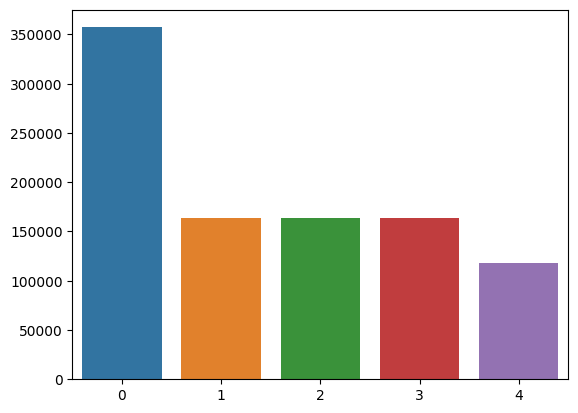

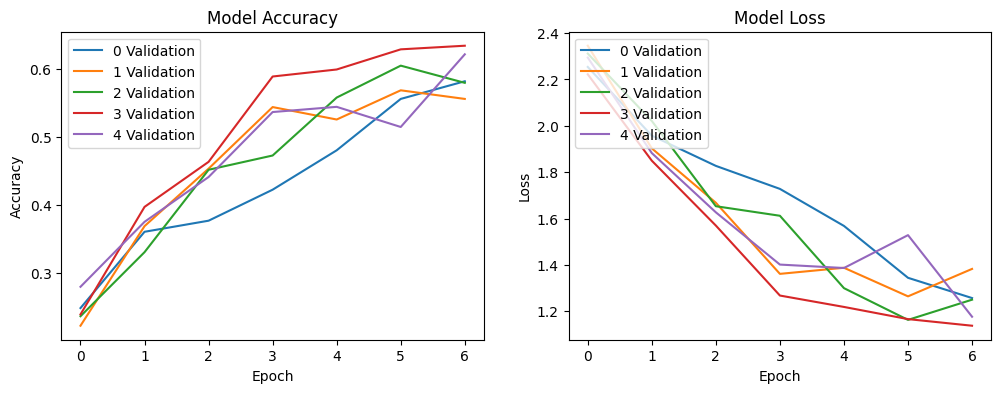

In [78]:
sns.barplot(x=list(range(5)), y=paramLength)
plot_multiple_training_history(historyObjs)

Surprisingly the lightest model of all does the best here. I have more confidence it in. I will try to use that.

### 128 x 128

In [79]:
class SmallerConvTransformer(keras.Model):
    def __init__(self, patch_size, image_size, embedding, transformer_layers, conv_layers,transformer_count):
        super().__init__()
        self.convPatch = ConvolutionalPatching(conv_layers)
        self.conv = Convolution_Model(conv_layers)
        self.compress = Convolution_Model([32])
        self.pool= MaxPooling2D()
        self.embedding = AddPosEmbedding(32,self.conv)
        self.transformer = Transformer(4, 64, transformer_layers,0.1)
        self.normalise = LayerNormalization(epsilon=1e-6)
        self.dense = Dense(1)
        self.classifier = Dense(15)
        self.transformer_count = transformer_count
    
    def call(self,images):
        x = self.compress(images)
        x = self.pool(x)
        
        x = self.convPatch(x)
        
        x = self.embedding(x)
        for i in range(self.transformer_count):
            x = self.transformer(x)
        x = self.normalise(x)
        weights = self.dense(x)
        weights =  tf.nn.softmax(weights,axis=1)
        x = tf.matmul(weights,x, transpose_a=True)
        x = tf.squeeze(x, -2)
        prediction = self.classifier(x)
        return prediction

In [80]:
tryParams2 = [SmallerConvTransformer(16,128,128,[256,128],[64,128],8),
            SmallerConvTransformer(16,128,64,[128,64],[64,64],6),
            SmallerConvTransformer(32,128,32,[128,64],[64,64],4),
            SmallerConvTransformer(32,128,32,[128,64],[64,64],3),
            SmallerConvTransformer(32,128,32,[64,64],[32,64],3)]
historyObjsLarge = []
paramLengthLarge = []
count = 0
for i in tryParams2:
    i.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )
    history2 = i.fit(
        train_large,validation_data=val_large,
        epochs=7
    )
    paramLengthLarge.append(i.count_params())
    historyObjsLarge.append((history2,f"{count}"))
    count += 1

Epoch 1/7
565/565 [==============================] - 32s 39ms/step - loss: 2.4243 - accuracy: 0.1788 - val_loss: 2.0631 - val_accuracy: 0.3100
Epoch 2/7
565/565 [==============================] - 21s 37ms/step - loss: 1.6639 - accuracy: 0.4358 - val_loss: 1.5573 - val_accuracy: 0.4487
Epoch 3/7
565/565 [==============================] - 21s 37ms/step - loss: 1.3005 - accuracy: 0.5640 - val_loss: 1.1528 - val_accuracy: 0.6140
Epoch 4/7
565/565 [==============================] - 21s 37ms/step - loss: 1.0803 - accuracy: 0.6430 - val_loss: 1.0607 - val_accuracy: 0.6563
Epoch 5/7
565/565 [==============================] - 21s 37ms/step - loss: 0.9151 - accuracy: 0.7039 - val_loss: 0.8818 - val_accuracy: 0.7160
Epoch 6/7
565/565 [==============================] - 21s 37ms/step - loss: 0.7649 - accuracy: 0.7489 - val_loss: 1.1499 - val_accuracy: 0.5990
Epoch 7/7
565/565 [==============================] - 21s 37ms/step - loss: 0.6927 - accuracy: 0.7739 - val_loss: 0.8302 - val_accuracy: 0.7267

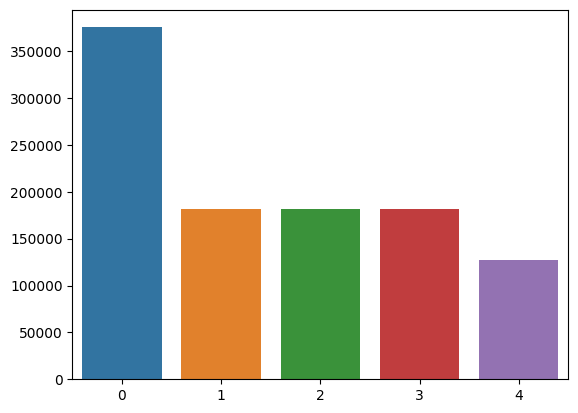

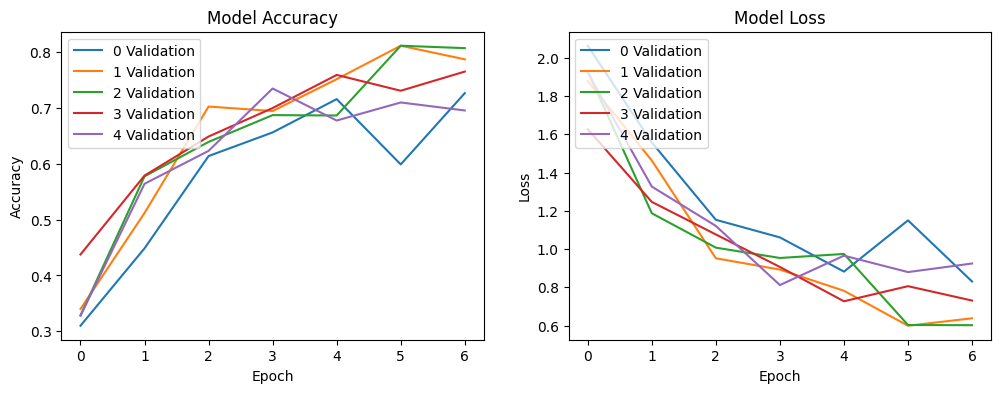

In [81]:
sns.barplot(x=list(range(5)), y=paramLengthLarge)
plot_multiple_training_history(historyObjsLarge)

Model 3 has a stronger performance and seems to have more potential so I will use that. 

## Final Training
Now that we have found the most lean models for this task, we will train the models for longer and also utilise the augmented data to create the final models which are the best at predicting vegetable images.

In [82]:
for i in train_small.take(1):
    print(i[0].shape)

(32, 31, 31, 1)


In [83]:
(train_small.unbatch().batch(32))

<_BatchDataset element_spec=(TensorSpec(shape=(None, 31, 31, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [84]:
final_31 = ConvTransformerTry(12,31,32,[64,64],[32,64],2)

final_31.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )

history = final_31.fit(
    train_small, validation_data=val_small,
    epochs=30, callbacks=[es,reduce_lr]
)

history2 = final_31.fit(
    train_mixup_small.unbatch().batch(512), validation_data=val_small,
    epochs=30, callbacks=[es,reduce_lr]
)
final_31.save('final_small.keras')

Epoch 1/30
565/565 [==============================] - 12s 12ms/step - loss: 2.1541 - accuracy: 0.2844 - val_loss: 2.2130 - val_accuracy: 0.2803 - lr: 0.0010
Epoch 2/30
565/565 [==============================] - 6s 11ms/step - loss: 1.5538 - accuracy: 0.4811 - val_loss: 1.7736 - val_accuracy: 0.3877 - lr: 0.0010
Epoch 3/30
565/565 [==============================] - 6s 11ms/step - loss: 1.3080 - accuracy: 0.5654 - val_loss: 1.5648 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 4/30
565/565 [==============================] - 6s 11ms/step - loss: 1.1306 - accuracy: 0.6287 - val_loss: 1.4049 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 5/30
565/565 [==============================] - 6s 11ms/step - loss: 0.9958 - accuracy: 0.6711 - val_loss: 1.3666 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 6/30
565/565 [==============================] - 6s 11ms/step - loss: 0.8877 - accuracy: 0.7052 - val_loss: 1.2584 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 7/30
565/565 [==============================] - 6s 11ms/s

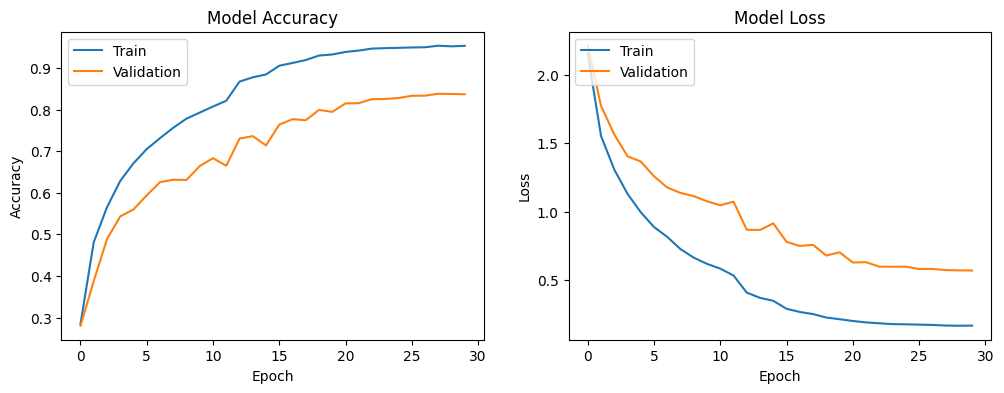

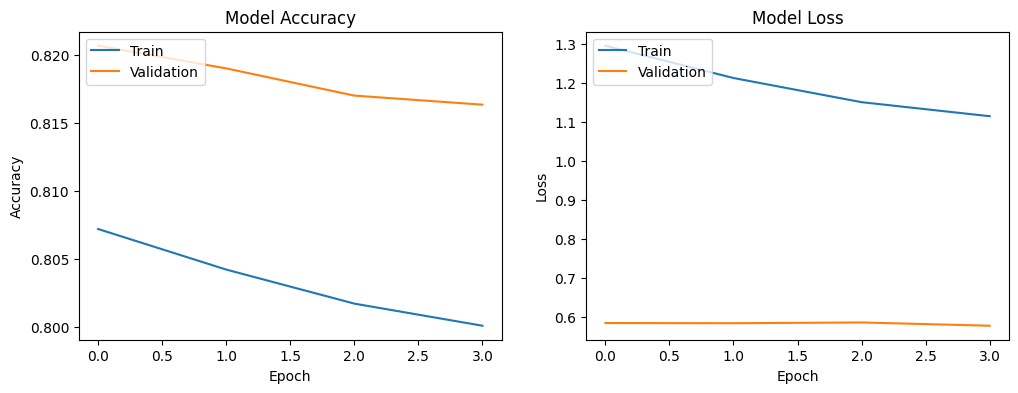

In [85]:
plot_training_history(history)
plot_training_history(history2)

In [86]:
final_128 = SmallerConvTransformer(32,128,32,[128,64],[64,64],3)

final_128.compile(
        optimizer="adam",
        loss= keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy" ],
    )
history = final_128.fit(
    train_large, validation_data=val_large,
    epochs=30, callbacks=[es,reduce_lr]
)


history2 = final_128.fit(
    train_mixup_large.unbatch().batch(512), validation_data=val_large,
    epochs=30, callbacks=[es,reduce_lr]
)

final_128.save('final_large.keras')

Epoch 1/30
565/565 [==============================] - 18s 20ms/step - loss: 2.1722 - accuracy: 0.2804 - val_loss: 1.8638 - val_accuracy: 0.3740 - lr: 0.0010
Epoch 2/30
565/565 [==============================] - 11s 20ms/step - loss: 1.3330 - accuracy: 0.5620 - val_loss: 1.3341 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 3/30
565/565 [==============================] - 11s 20ms/step - loss: 1.0011 - accuracy: 0.6721 - val_loss: 1.2301 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 4/30
565/565 [==============================] - 11s 20ms/step - loss: 0.7926 - accuracy: 0.7431 - val_loss: 0.7904 - val_accuracy: 0.7463 - lr: 0.0010
Epoch 5/30
565/565 [==============================] - 11s 19ms/step - loss: 0.6510 - accuracy: 0.7895 - val_loss: 0.7667 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 6/30
565/565 [==============================] - 11s 19ms/step - loss: 0.5513 - accuracy: 0.8208 - val_loss: 0.7149 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 7/30
565/565 [==============================] - 11s 

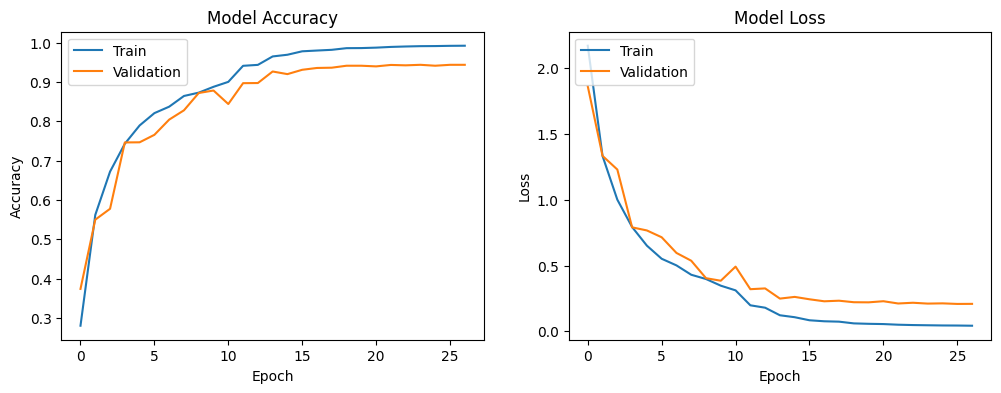

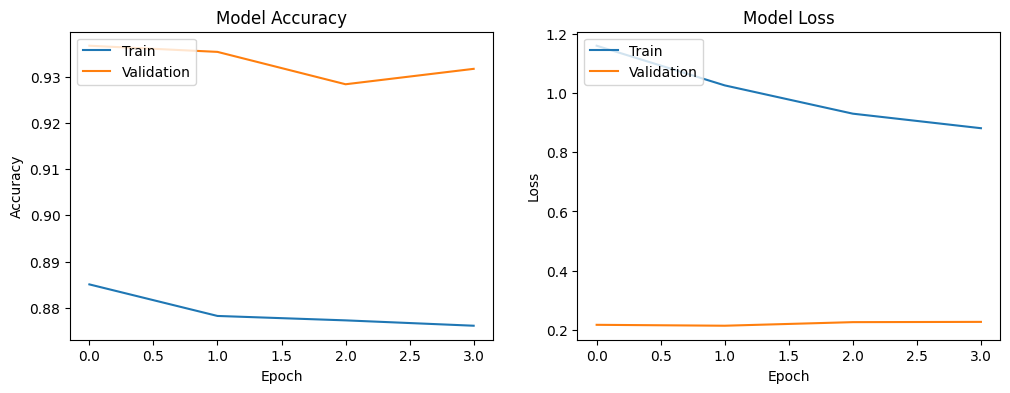

In [87]:
plot_training_history(history)
plot_training_history(history2)

## Evaluation
Now it is time to score these models and analyse the errors they made.

94/94 [==============================] - 1s 6ms/step - loss: 0.5758 - accuracy: 0.8180
Loss: 0.5758219957351685
Accuracy: 0.8180000185966492


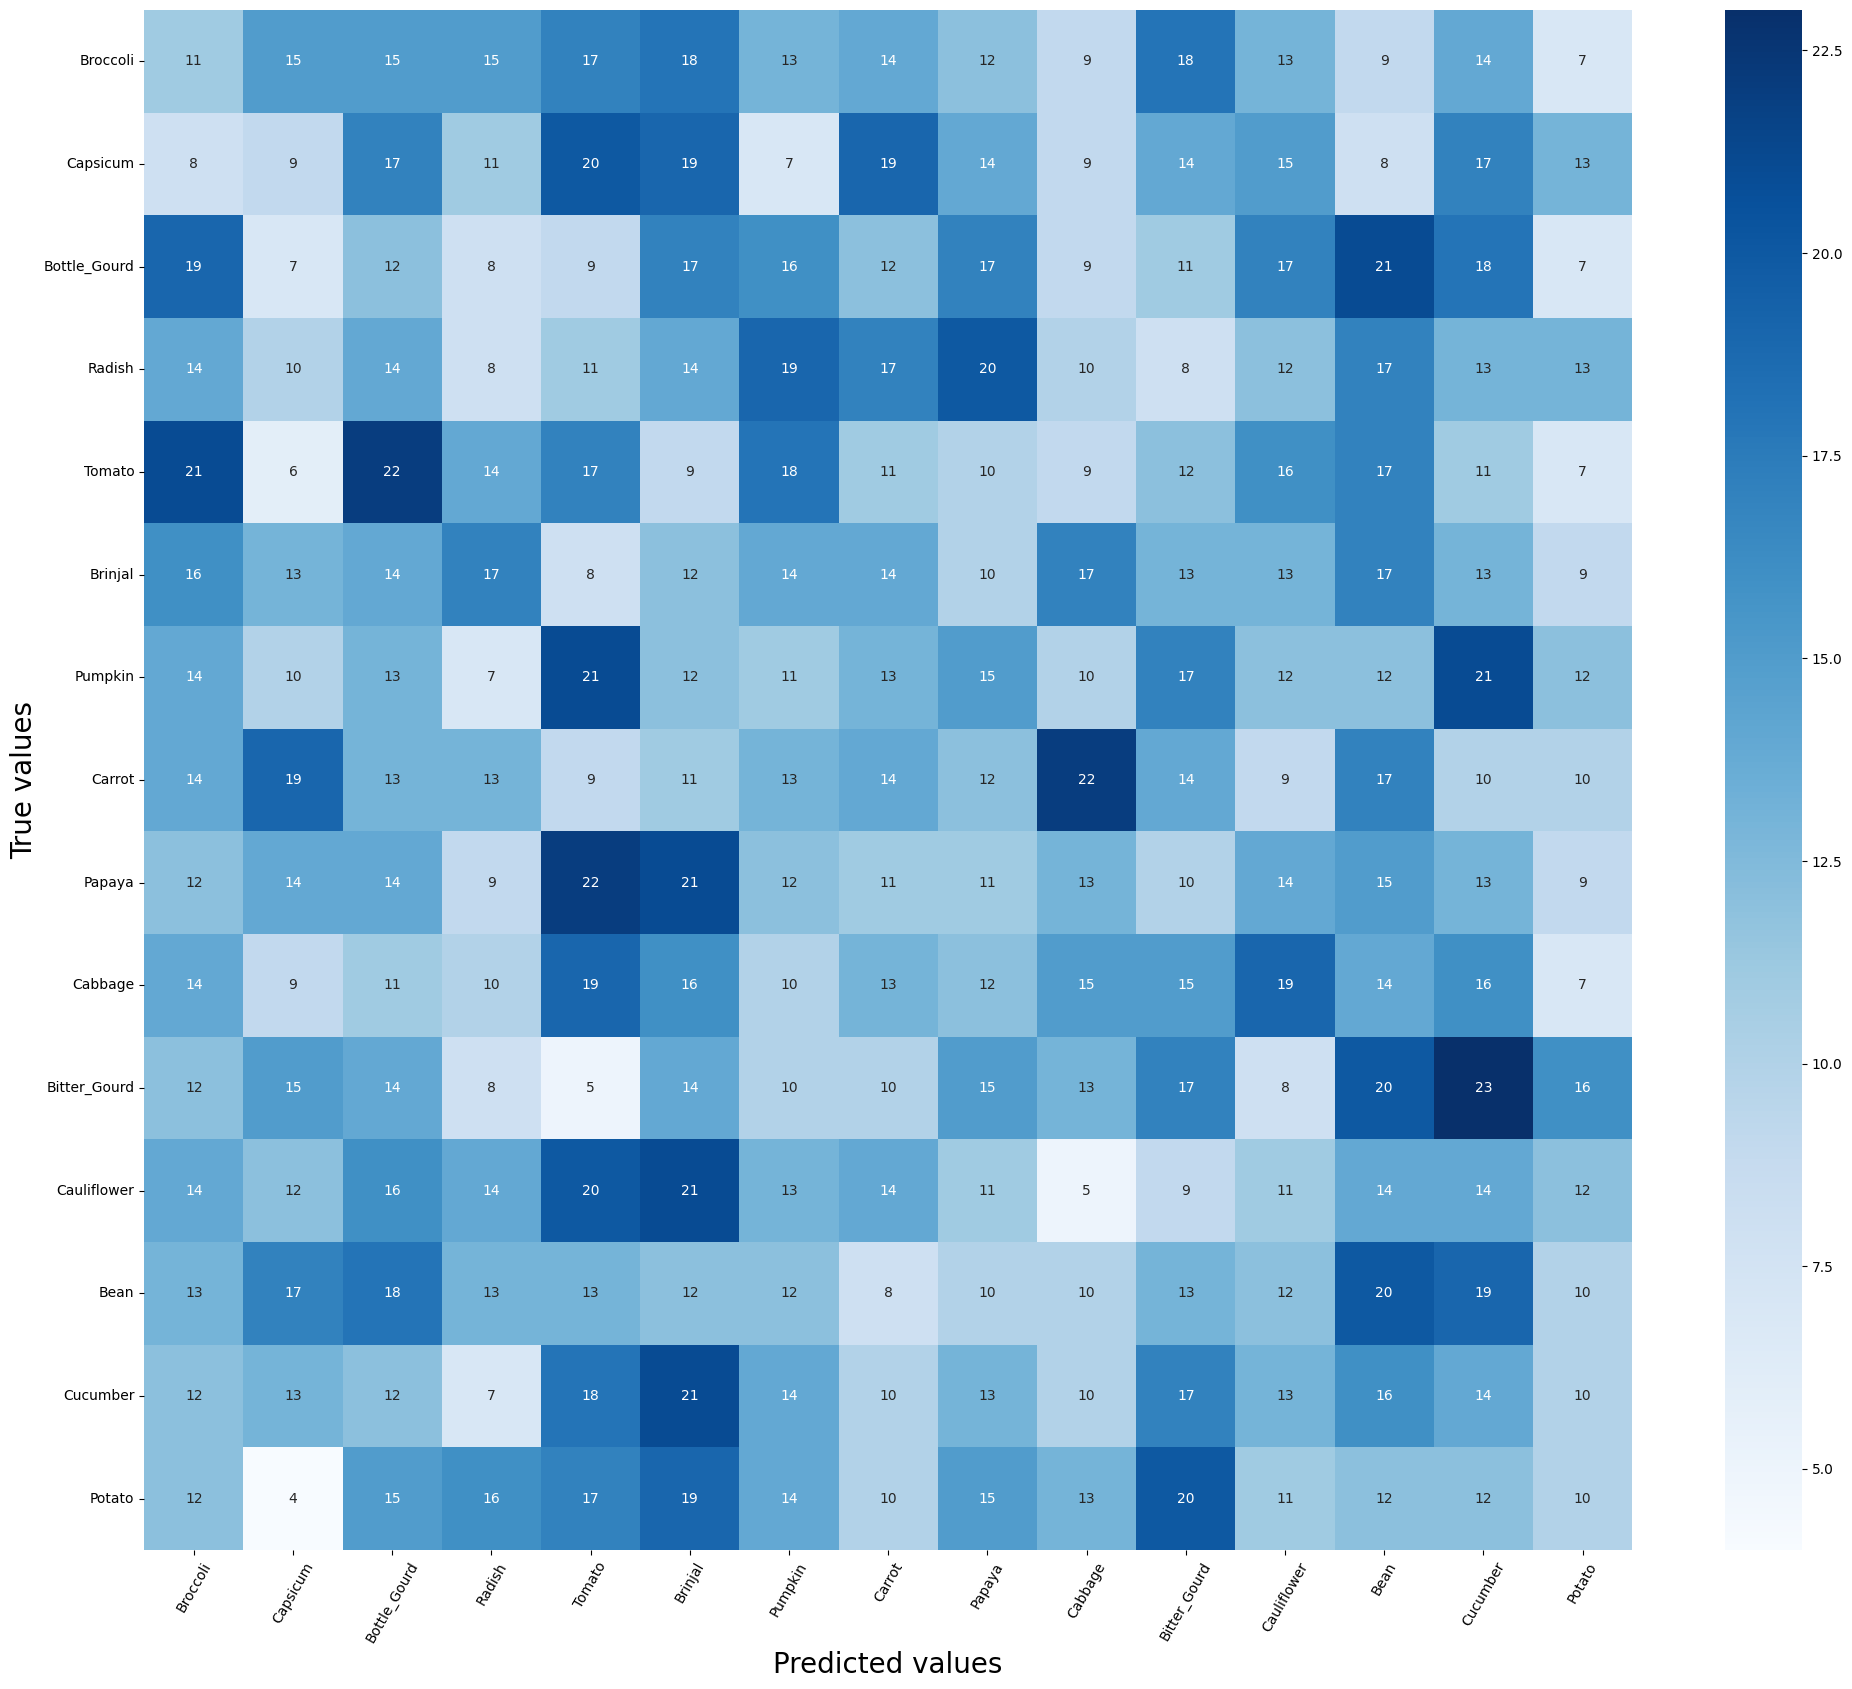

In [88]:
pred_31 = final_31.predict(test_small)
pred_class = tf.argmax(pred_31,axis=1).numpy()

evaluation_results = final_31.evaluate(test_small)

print("Loss:", evaluation_results[0])
print("Accuracy:", evaluation_results[1])

true_class = []
for _,label in test_small.unbatch():
    true_class.append(label.numpy().argmax())

make_confusion_matrix(true_class,pred_class)

Final test accuracy of 82.3% is pretty good. Using the confusion matrix we can tell that the model is confusing cucumbers and potatos, cauliflowers and bitter_gourd, potato and bottle_gourd. This seems pretty reasonable as the images are pretty difficult to learn for a human.

94/94 [==============================] - 1s 9ms/step - loss: 0.2307 - accuracy: 0.9283
Loss: 0.23074230551719666
Accuracy: 0.9283333420753479


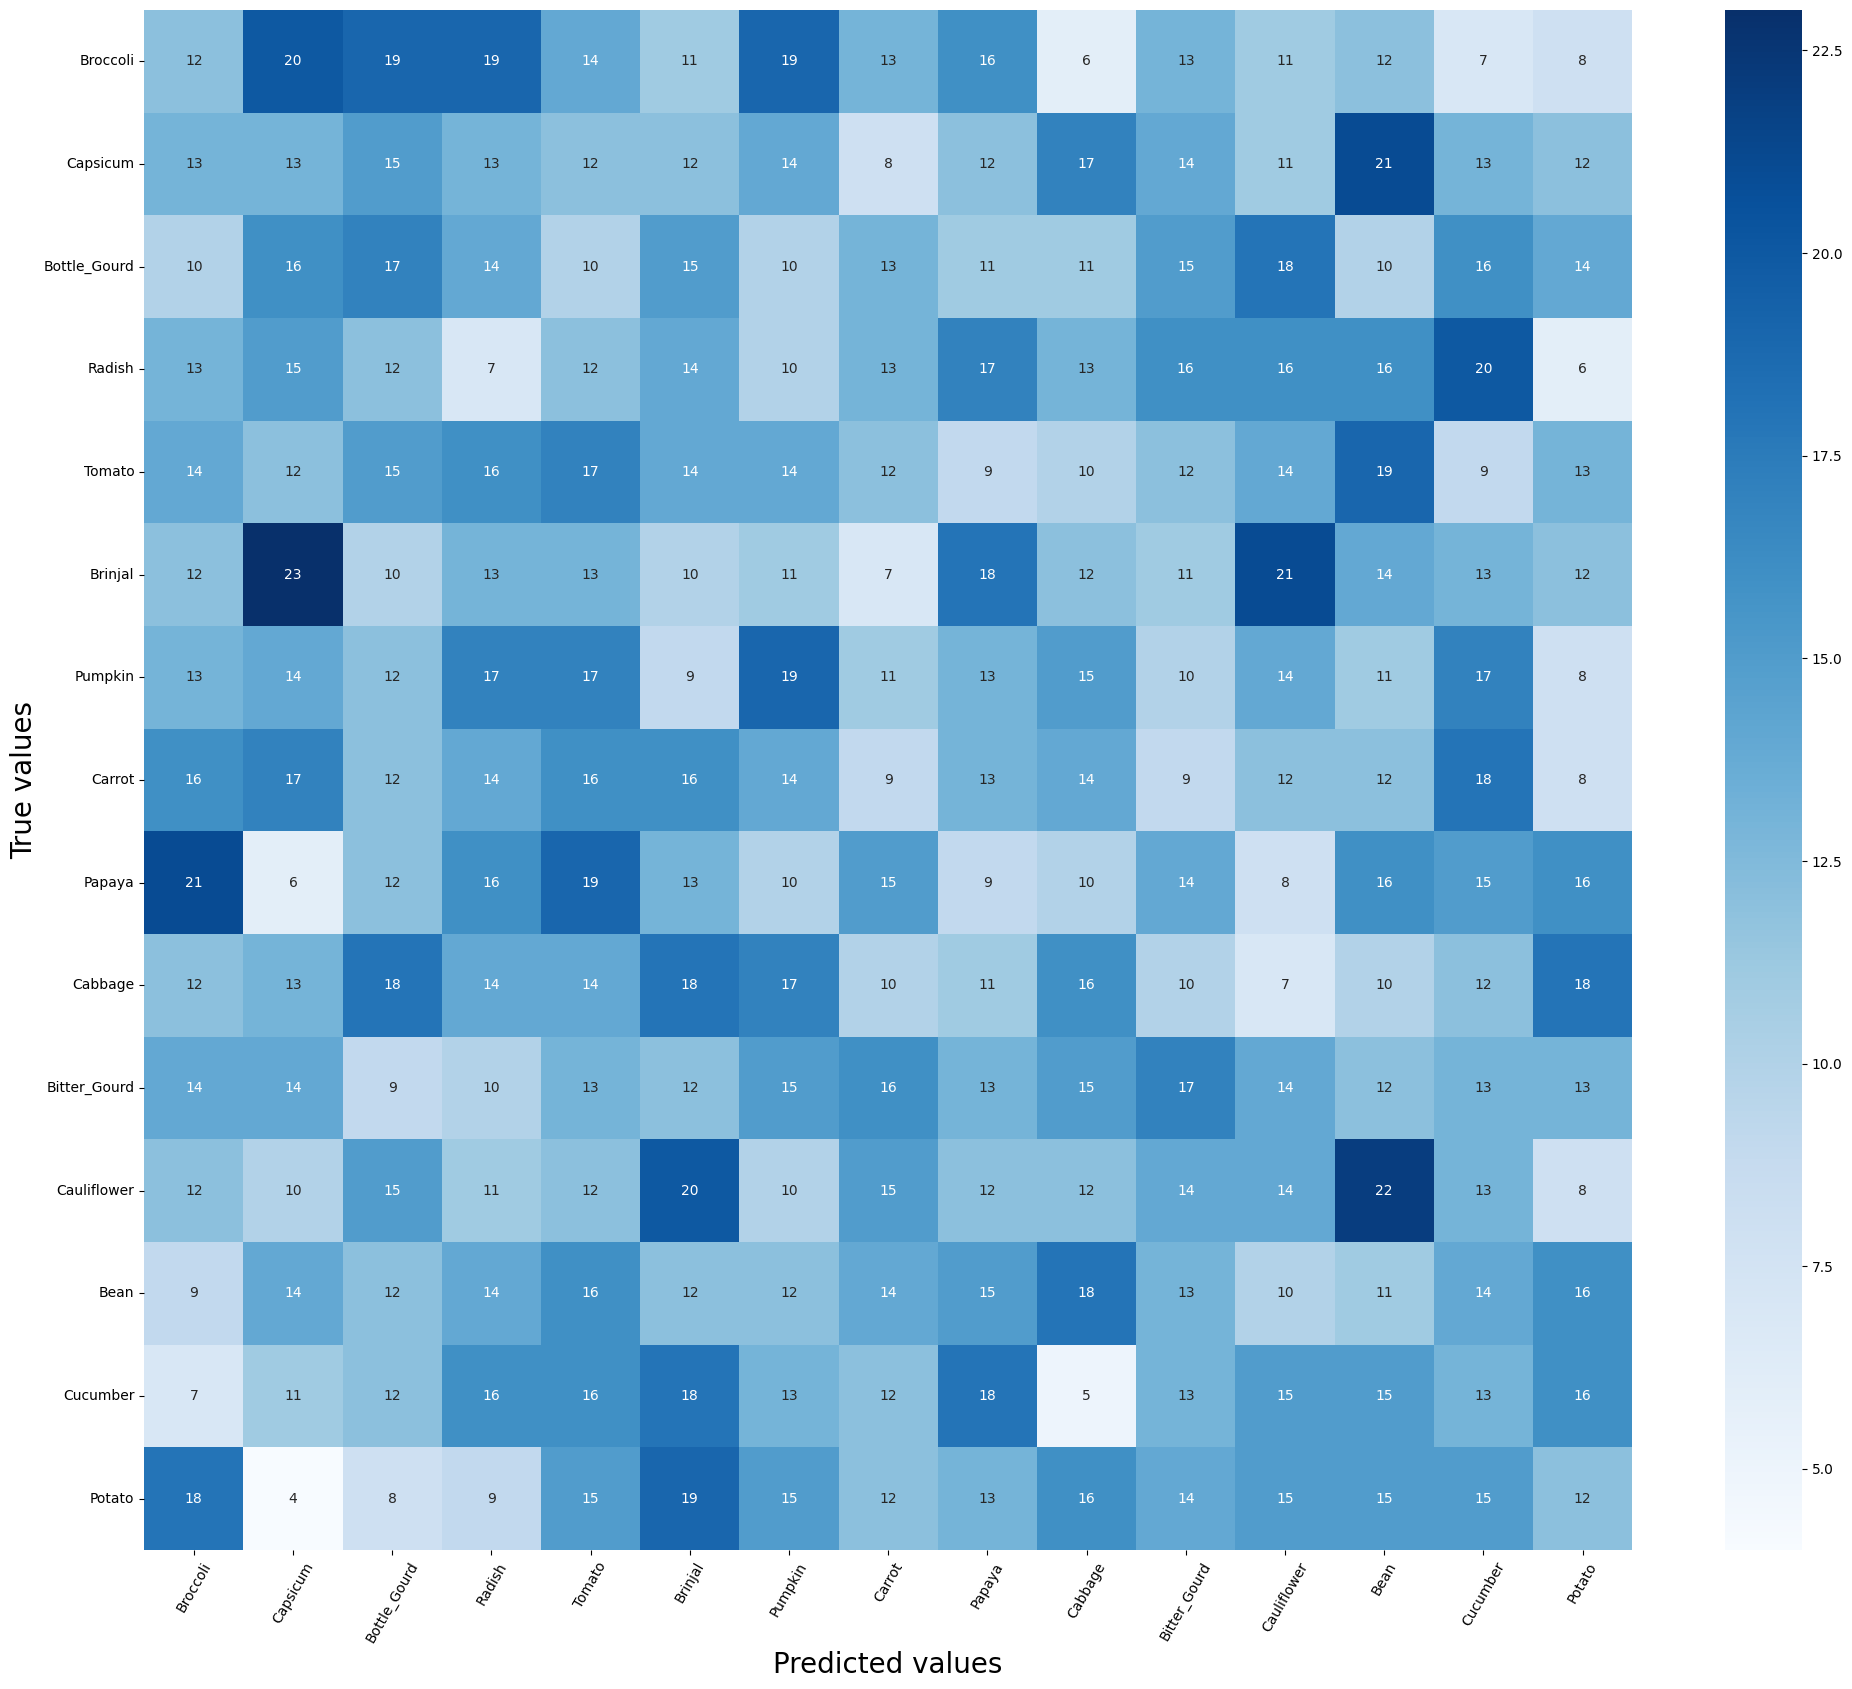

In [89]:
pred_128 = final_128.predict(test_large)
pred_class = tf.argmax(pred_128,axis=1).numpy()

evaluation_results = final_128.evaluate(test_large)

print("Loss:", evaluation_results[0])
print("Accuracy:", evaluation_results[1])

true_class = []
for _,label in test_large.unbatch():
    true_class.append(label.numpy().argmax())

make_confusion_matrix(true_class,pred_class)

With a test accuracy of 92.8% I would say the model performs very well. If we look at the confusion matrix, the model mostly confuses similiar looking vegetables like beans and bottle_gourd, radish and tomato and so on. I would say this entire thing was pretty successful.